# **SIOC 221A - Analysis of Physical Oceanographic Data (A) - Problem 4** 

# Caique Dias Luko 






### We’ve talked about least-squares fitting, and we’ve talked about the Fourier transform, so it’s time for us to test both strategies out using the same data set. Here we’ll use the automated pressure data from the Scripps Pier. Use the function that you wrote previously.

In [1]:
def GetPierDataMY(path,year_start=None,year_end=None):
    # This function returns a multi-year temperature, pressure and time pier records 
    # (http://sccoos.org/thredds/catalog/autoss/catalog.html)
    
    # The path must be a directory containing all the pier data from 2005-2021
    # year_start is the start year of interest (must be between 2005 and 2021)
    # year_end is the end year of interest (must be between 2005 and 2021)
    # Default is year_start and year_start equal to None (all the 2005-2021 record will be loaded)
    # CDL SIO211A 10/08/2022

    # Important packages
    import netCDF4 as nc              # Read nc files
    import datetime                   # Manage time vectors
    import pandas as pd               # Useful to work with DataFrames and also to manage time
    from glob import glob             # To load a lot of files with same extension
    import numpy as np                # Using arrays
    
    # Getting path from all the files (2005-2021)
    files = glob(path+'scripps*.nc')
    files.sort()
    files=np.array(files)
    years = np.arange(2005,2022,1)
    if (year_start != None) and (year_end != None): # Selecting files from the chosen years
        files = files[(years>=year_start)&(years<=year_end)]
        
    # Loading loop for the selected files
    for f in range(len(files)):
        # Loading time
        dat = nc.Dataset(files[f])
        time = dat['time'][:]
    
        # Converting time vector
        timev = [str(datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(d))) for d in time]
        timev = pd.to_datetime(timev)
        # Loading temp and pressure
        temp = dat['temperature']
        pres = dat['pressure']
        
        # Concatenating data from different files
        if f==0:
                   TIMEV,TEMP,PRES=np.array(timev),np.array(temp),np.array(pres)
        else:
                   TIMEV = np.concatenate((TIMEV,np.array(timev)))
                   TEMP = np.concatenate((TEMP,np.array(temp)))
                   PRES = np.concatenate((PRES,np.array(pres)))
                
    return pd.DataFrame({'temp':TEMP,'pres':PRES,'time':TIMEV}) # Pier object

import numpy as np
import pandas as pd

# Directory with all the pier data (2005-2021)
path = '/home/caique/Documentos/PhD_Courses/SIOC221A_DATA1/Homeworks/data/'

# Loading Pier record for 2021
pier=GetPierDataMY(path,year_start=2021,year_end=2021)

### For 2021, we will use data records 70521 through 88190, since these are nearly evenly spaced in time. There are 4 gaps, that we will need to fill.

In [2]:
# indexes in python are equal to matlab indexes - 1
pres,timev=np.array(pier.pres)[70520:88189],pd.to_datetime(np.array(pier.time))[70520:88189]

#Creating new time and pressure vectors. Time has now constant timesteps. Pressure has the same size as the new time vector
timevnew=np.arange(timev[0],timev[-1]+np.diff(timev)[0],np.diff(timev)[0])
presnew = np.ones(timevnew.shape[0])*np.nan
# Finding indexes of time new which are equal to the prior time vector
idx=np.array([np.where(timevnew==i)[0][0] for i in timev])
# Setting the new pressure vector equal to the pressure in the prior vector, where both time vectors match
presnew[idx]=pres.copy()
# Finding gaps in the new pressure vector
nans = np.where(np.isnan(presnew))[0]
# Computing new vals for gaps and filling them
newvals = np.array([0.5*(presnew[i-1]+presnew[i+1]) for i in nans])
presnew[nans]=newvals

### 1. Visual evaluation. Plot the time series of pressure data from 2021, and examine the time increments between adjacent measurements. (You can do this in Matlab using the “diff” command or in python using “numpy.diff”, for example.) Are the data always uniformly spaced? What is the increment between measurements? How long is the time record? Are there other portions of the 2021 record that also have reliable uniform spacing?

In [3]:
tstep=np.unique(np.diff(timevnew))
tstep

array([240000000000], dtype='timedelta64[ns]')

There is only one timestep throughout the whole vector. The data is always uniformly spaced.

In [4]:
# Converting nanoseconds to minutes
tstep=(float(tstep[0])*1e-9)/60
tstep

4.000000000000001

The time step is of 4 minutes.

In [5]:
N = timevnew.shape[0]
L = tstep*N
round(L/(24*60),2)

49.09

The time record has a lenght of about 49 days.

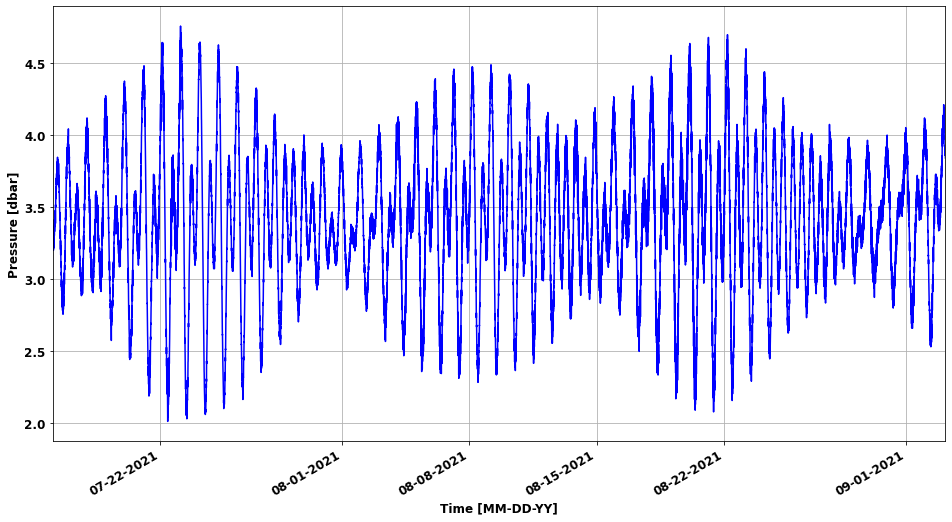

In [6]:
# Defining function to plot the data
def subplot_time(timev,var,varstr,ax,c,labels=None):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    if labels!=None:
        plt.plot(timev,var,label=labels,color=c)
        plt.legend(loc='best')
    else:
        plt.plot(timev,var,color=c)
    plt.xlim(timev[0],timev[-1])
    plt.xlabel('Time [MM-DD-YY]',fontsize=12,weight='bold')
    plt.ylabel(varstr,fontsize=12,weight='bold')
    # Setting datetick format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right') 

# Plotting packages
import matplotlib.pyplot as plt   # Plots
from matplotlib import rc         # Figure fonts

#Creating plot
fig =plt.figure(figsize=(16,8))
rc('font',size=12)    
rc('font',weight='bold') 
rc('xtick',labelsize=12)  
rc('ytick',labelsize=12)

ax1 = fig.add_subplot(111)
subplot_time(timev,pres,'Pressure [dbar]',ax1,c='blue')
plt.grid()

### 2. Least-squares fit. Least-squares fit a mean and 3 major tidal constituents to your data. Plot the raw and model solution. What is the mean, and what are the total amplitudes of the tidal constituents? (Total amplitude should be determined from the square root of the sum of the squares of the sine and cosine amplitudes.)

$$
\begin{array}{ccc}
\textbf{Symbol} & \textbf{Name}           & \textbf{Period (hours)} \\
\textbf{O1}     & Principal\,lunar\,diurnal & 25.82                   \\
\textbf{K1}     & Luni-solar\,diurnal      & 23.93                   \\
\textbf{M2}     & Principal\,lunar         & 12.42                  
\end{array}
$$

Let's use the following model:

$$
{\bf Y}=M + A_{O1} sin(\omega_{O1} {\bf t}) + B_{O1} cos(\omega_{O1} {\bf t}) + A_{K1} sin(\omega_{K1} {\bf t}) + B_{K1} cos(\omega_{K1} + A_{M2} sin(\omega_{M2} {\bf t}) + B_{M2} cos(\omega_{M2} {\bf t}){\bf t}) ,\hspace{3cm} (7),
$$

We can rewrite this equation in matricial form:

$$
\underbrace{\left[\begin{array}{c}
                              Y_1  \\
                              Y_2  \\
                              Y_3  \\
                              \vdots \\
                              Y_N  \end{array}\right]}_{\bf Y} = \underbrace{\left[\begin{array}{c}
                              M  \\
                              A_{O1}  \\
                              B_{O1}  \\ 
                              A_{K1}  \\
                              B_{K1}  \\ 
                              A_{M2}  \\
                              B_{M2}  \\ 
                              \end{array}\right]}_{\bf x} \underbrace{\left[\begin{array}{ccccccc}
                              1 & sin(\omega_{O1} t_1) & cos(\omega_{O1} t_1) & sin(\omega_{K1} t_1) & cos(\omega_{K1} t_1) & sin(\omega_{M2} t_1) & cos(\omega_{M2} t_1) \\
                              1 & sin(\omega_{O1} t_2) & cos(\omega_{O1} t_2) & sin(\omega_{K1} t_2) & cos(\omega_{K1} t_2) & sin(\omega_{M2} t_2) & cos(\omega_{M2} t_2) \\
                              1 & sin(\omega_{O1} t_3) & cos(\omega_{O1} t_3) & sin(\omega_{K1} t_3) & cos(\omega_{K1} t_3) & sin(\omega_{M2} t_3) & cos(\omega_{M2} t_3) \\
                              \vdots & \vdots & \vdots & \vdots & \vdots\\
                              1 & sin(\omega_{O1} t_N) & cos(\omega_{O1} t_N) & sin(\omega_{K1} t_N) & cos(\omega_{K1} t_N) & sin(\omega_{M2} t_N) & cos(\omega_{M2} t_N) \\
\end{array}\right]}_{\bf A}.
$$


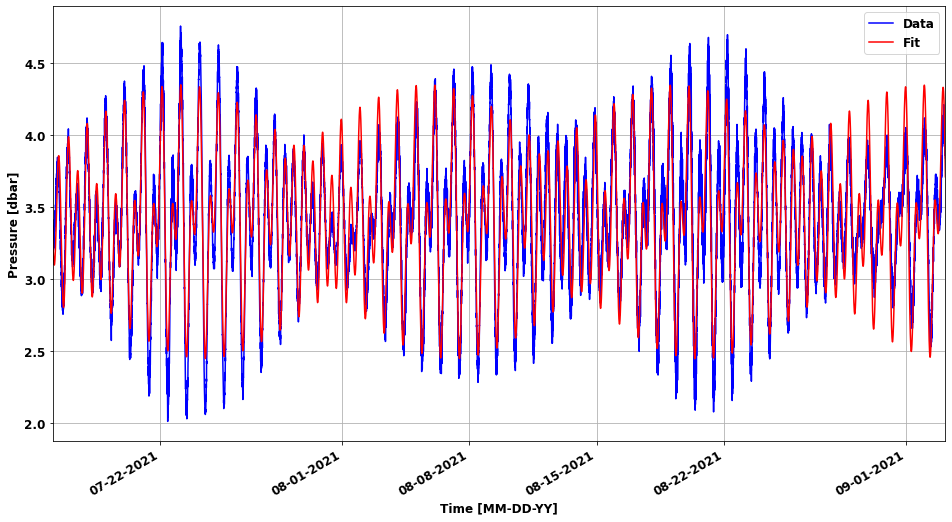

In [7]:
# Writting function to perform the least squares fit to O1, K1 and M2 tide components
def tidecomp3(var,t):
    # t in hours
    from scipy.linalg import inv
    A = np.array([np.ones(t.shape[0]),np.sin(2*np.pi*t/25.82), np.cos(2*np.pi*t/25.82),np.sin(2*np.pi*t/23.93), np.cos(2*np.pi*t/23.93),np.sin(2*np.pi*t/12.42), np.cos(2*np.pi*t/12.42) ]).T
    x = np.dot(inv(np.dot(A.T, A)), np.dot(A.T,var)) # Coefficients
    fit = np.dot(A, x) # Fit
    return fit,x

# time vector in hours
t = np.arange(0,L,tstep)/(60)
# Fit
presfit,presvals = tidecomp3(presnew,t)

#Creating plot
fig =plt.figure(figsize=(16,8))
rc('font',size=12)    
rc('font',weight='bold') 
rc('xtick',labelsize=12)  
rc('ytick',labelsize=12)

ax1 = fig.add_subplot(111)
subplot_time(timevnew,presnew,'Pressure [dbar]',ax1,c='blue',labels='Data')
subplot_time(timevnew,presfit,'Pressure [dbar]',ax1,c='red',labels='Fit')
plt.grid()

In [8]:
print('The mean is:         ',round(presvals[0],2),' dbar')
print('The O1 amplitude is: ',round(np.sqrt(presvals[1]**2+presvals[2]**2),2),' dbar')
print('The K1 amplitude is: ',round(np.sqrt(presvals[3]**2+presvals[4]**2),2),' dbar')
print('The M2 amplitude is: ',round(np.sqrt(presvals[5]**2+presvals[6]**2),2),' dbar')

The mean is:          3.41  dbar
The O1 amplitude is:  0.23  dbar
The K1 amplitude is:  0.37  dbar
The M2 amplitude is:  0.48  dbar


### 3. Fourier transform. Now Fourier transform your data. (Don’t worry about any of the details of computing a spectrum for this exercise—just Fourier transform.)


In [9]:
import numpy as np
fft = np.fft.fftshift(np.fft.fft(presnew-np.nanmean(presnew)))
freq = np.fft.fftshift(np.fft.fftfreq(presnew.shape[0],d=4./(24*60)))

### a. Plot the real and imaginary parts of the Fourier transform. Find the peaks. What frequencies correspond to these peaks? Are they what you’d expect based on the known tidal frequencies?

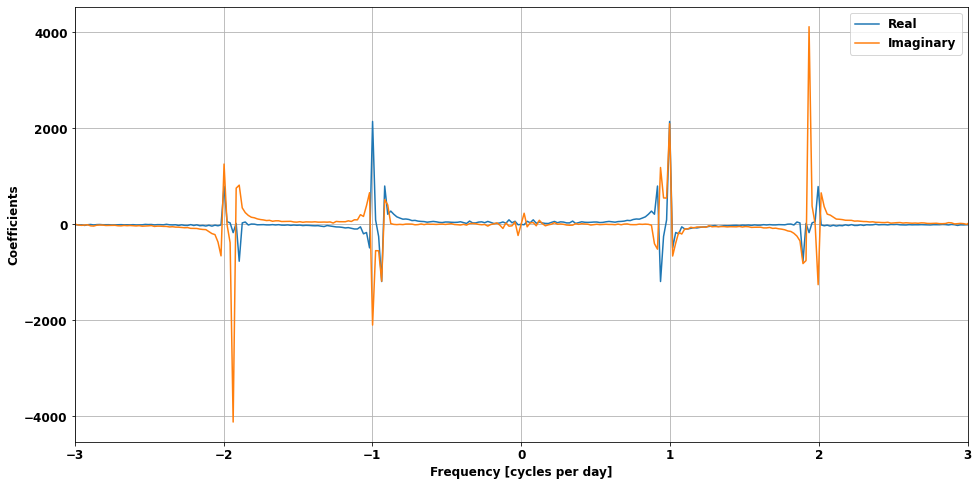

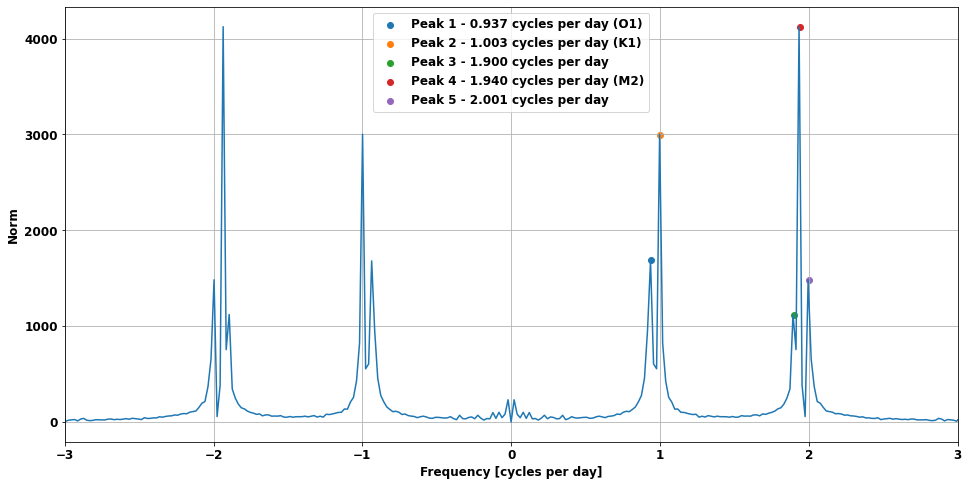

In [10]:
# Plotting Real and Imaginary part 
plt.figure(figsize=(16,8))
plt.plot(freq,fft.real,label='Real')
plt.plot(freq,fft.imag,label='Imaginary')
plt.legend(loc='best')
plt.xlabel('Frequency [cycles per day]',fontsize=12,weight='bold')
plt.ylabel('Coefficients',fontsize=12,weight='bold')
plt.xlim(-3,3)
plt.grid()

# Plotting Amplitude 
plt.figure(figsize=(16,8))
plt.plot(freq,abs(fft))
plt.scatter(0.937,1689,label='Peak 1 - 0.937 cycles per day (O1)')
plt.scatter(1.003,2997,label='Peak 2 - 1.003 cycles per day (K1)')
plt.scatter(1.900,1112,label='Peak 3 - 1.900 cycles per day')
plt.scatter(1.940,4121,label='Peak 4 - 1.940 cycles per day (M2)')
plt.scatter(2.001,1482,label='Peak 5 - 2.001 cycles per day')
plt.legend(loc='best')
plt.xlabel('Frequency [cycles per day]',fontsize=12,weight='bold')
plt.ylabel('Norm',fontsize=12,weight='bold')
plt.xlim(-3,3)
plt.grid()



### b. Now use the Fourier coefficients to identify the mean pressure and the amplitudes of the major peaks. (Hint: to determine the amplitudes of the oscillatory modes, you’ll need to multiply by a factor of 2 to account for both the positive and negative frequencies.)

In [11]:
print('Peak 1 amplitude is equal to:',str(2*1689))
print('Peak 2 amplitude is equal to:',str(2*2997))
print('Peak 3 amplitude is equal to:',str(2*1112))
print('Peak 4 amplitude is equal to:',str(2*4121))
print('Peak 5 amplitude is equal to:',str(2*1482))

fft2 = np.fft.fftshift(np.fft.fft(presnew))
peakmean = np.nanmax(fft2) # Checked in the graph that is the maximum

print('Mean amplitude is equal to:',str(2*abs(peakmean)))


Peak 1 amplitude is equal to: 3378
Peak 2 amplitude is equal to: 5994
Peak 3 amplitude is equal to: 2224
Peak 4 amplitude is equal to: 8242
Peak 5 amplitude is equal to: 2964
Mean amplitude is equal to: 120596.19601035118


### c. Do these spectral peaks align with the results from the least-squares fit? Is there anything you could do to further check your results? 

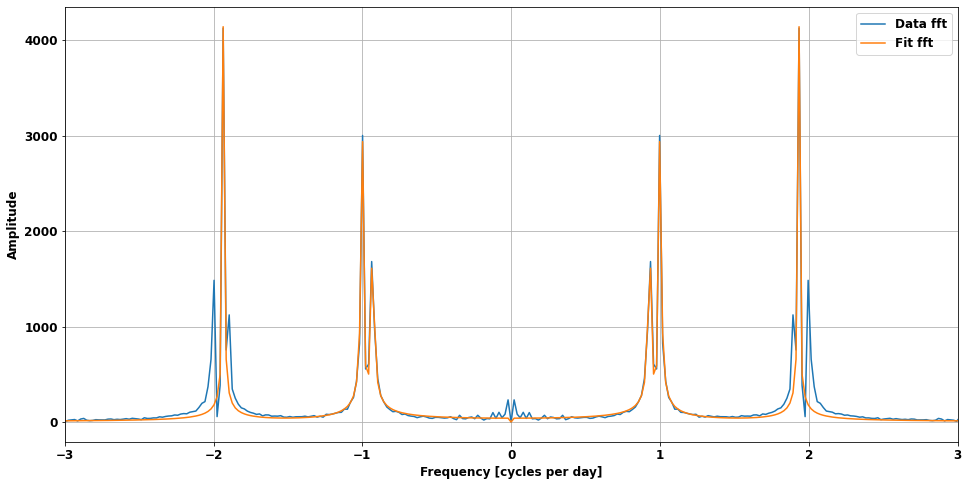

In [12]:
fftfit = np.fft.fftshift(np.fft.fft(presfit-np.nanmean(presfit)))

# Plotting Amplitude 
plt.figure(figsize=(16,8))
plt.plot(freq,abs(fft),label='Data fft')
plt.plot(freq,abs(fftfit),label='Fit fft')
plt.legend(loc='best')
plt.xlabel('Frequency [cycles per day]',fontsize=12,weight='bold')
plt.ylabel('Amplitude',fontsize=12,weight='bold')
plt.xlim(-3,3)
plt.grid()


Computing the Fourier Transform of the fit gives us a very similar distribution. The O1, K1 and M2 peaks have the same amplitude from the data Fourier Transform. The results are very well aligned with the fit. 

### d. Now plot the spectral energy (based on the squared magnitude of the Fourier coefficients) as a function of frequency. Is the spectrum red, white, or blue?

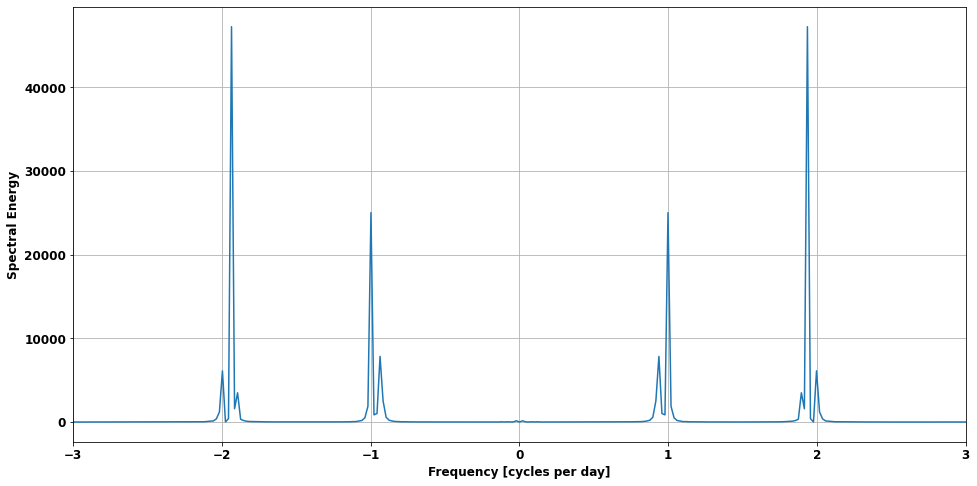

In [13]:
energy=(abs(fft)**2)/(1./(4./(24*60)))

# Plotting Amplitude 
plt.figure(figsize=(16,8))
plt.plot(freq,energy)
plt.xlabel('Frequency [cycles per day]',fontsize=12,weight='bold')
plt.ylabel('Spectral Energy',fontsize=12,weight='bold')
plt.xlim(-3,3)
plt.grid()


The spectra is blue, because there is more energy at the higher frequencies.